# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

#### Loading libraries

In [2]:
!pip install "numpy<2.0"


In [3]:
## The following libraries might be useful
!pip install -q langchain-openai
!pip install -U -q langchain-community
!pip install -U -q langchain-chroma
!pip install -U -q datasets
!pip install -U -q ragas
!pip install -U -q rouge_score
!pip install -U -q langchain
!pip install  -U -q onnxruntime
!pip install faiss-cpu

In [4]:
# Import essential libraries
import os
import openai
from langchain_openai import ChatOpenAI, OpenAI
from langchain_community.document_loaders import DirectoryLoader, TextLoader
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction
from langchain_openai import OpenAIEmbeddings

# from langchain.vectorstores import Chroma
from langchain.vectorstores import FAISS

from langchain.schema import Document
from chromadb.config import Settings
from langchain.text_splitter import RecursiveCharacterTextSplitter

from transformers import AutoTokenizer

import re
import logging
import random
import numpy as np

In [5]:
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from langchain.schema import Document
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\prita\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [6]:
# Load the files as documents

# Define root folder
rootfolder = "C:/Users/prita/Downloads/Starter and Dataset RAG Legal"

# Use limited document due to limit in token
documents_to_use = 20

# Use limited number of docs for test
docs_for_test = 20

loader = DirectoryLoader(
        path = rootfolder + "/rag_legal/corpus",
        glob = "**/*.txt",
        loader_cls = lambda path: TextLoader(path, encoding="utf-8")
)

documents = loader.load()

documents = documents[:documents_to_use]

print(f"{len(documents)} documents loaded.")


20 documents loaded.


#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [7]:
# Clean and preprocess the data by removing whitespace, email/phone, special characters, stopwords and lowercasing the words
stop_words = set(stopwords.words('english'))

def txtpreprocessing(text):
    text = text.lower()

    # remove email and phone number
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b', '', text)  # Emails
    text = re.sub(r'\+?\d[\d\s().-]{7,}', '', text)  # Phone numbers
    text = re.sub(r'^\s*\d+(?:\.\d+)*\.\s+', '', text, flags=re.MULTILINE) # removing bullet headers and numbers
    # Remove special characters
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text


In [8]:
#processing the text and handling missing/corrupted data and skipping and recording the skipped files 
cleaned_documents = []

for i, doc in enumerate(documents):
    try:
        #ensuring the doc has content and its in string form
        if not doc.page_content or not isinstance(doc.page_content, str):
            raise ValueError("Missing or invalid content")
            
        # Preprocessing the document content using txtpreprocessing function defined above
        cleaned_txt = txtpreprocessing(doc.page_content)
        
        # Creating new doc with cleaned text
        cleaned_doc = Document(page_content=cleaned_txt, metadata=doc.metadata)
        cleaned_documents.append(cleaned_doc)
        
    except Exception as e:
        # loggint the error and skipping
        print(f"skipping document {i} ({doc.metadatae.get('source', 'unknown')}): {e}")        

In [9]:
# Display first cleaned document type
type(cleaned_documents[0])

langchain_core.documents.base.Document

In [10]:
# Display first cleaned document
cleaned_documents[0].page_content

'mutual non disclosure agreement subject matter effective date agreement period 2017 exchange information 2017 period confidentiality agreement made effective date agreement noted parties background parties desire discussions relating subject matter purposes evaluating possible business relationship purpose parties may extend subject matter add additional parties executing one addenda agreement ii discussions may involve disclosure one party party confidential proprietary trade secret information licensors confidential information defined period exchange information iii parties recognize value confidential information mutual best interests maintain confidential proprietary secret nature confidential information therefore consideration subject matter mutual promises herein parties agree follows confidential information term confidential information used herein means nonpublic information relating subject matter disclosed either party affiliates defined agents applicable collectively ref

### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [11]:
# Calculate the average, maximum and minimum document length.
doc_lengths = [len(doc.page_content.split()) for doc in cleaned_documents] #if isinstance(doc.page_content, str)]

# Ensure there are valid documents
if doc_lengths:
    average_length = sum(doc_lengths) / len(doc_lengths)
    max_length = max(doc_lengths)
    min_length = min(doc_lengths)

    print(f"average document length: {average_length:.2f} words")
    print(f"maximum document length: {max_length} words")
    print(f"minimum document length: {min_length} words")

average document length: 934.95 words
maximum document length: 2104 words
minimum document length: 294 words


#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [12]:
# Find frequency of occurence of words
text_all = " ".join([doc.page_content for doc in cleaned_documents if isinstance(doc.page_content, str)])

#tokenizing the words in the text corpus
token = nltk.word_tokenize(text_all)

# filtering stop words, alphabetic words and words with length more than 2 as smaller words may not make any sense in this context
filterwords = [word for word in token if word.isalpha() and word not in stop_words and len(word)>2]

# counting words
word_count = Counter(filterwords)

In [13]:
# finding 20 most common and least common words from the list
most_common = word_count.most_common(20)
least_common = word_count.most_common()[-20:]

#printing words
print("20 Most Common Words:")
for word, freq in most_common:
    print(f"{word}: {freq}")

print("\n20 Least Common Words:")
for word, freq in least_common:
    print(f"{word}: {freq}")

20 Most Common Words:
party: 665
information: 638
agreement: 583
confidential: 419
shall: 380
disclosing: 240
data: 222
receiving: 216
parties: 206
disclosure: 186
may: 154
recipient: 137
use: 136
written: 90
disclose: 86
without: 83
terms: 80
prior: 78
business: 77
access: 77

20 Least Common Words:
handshake: 1
mediation: 1
creation: 1
insurers: 1
transmitting: 1
inspected: 1
consented: 1
broadly: 1
accorded: 1
pending: 1
reserved: 1
cumulative: 1
consequential: 1
lost: 1
profits: 1
revenue: 1
premised: 1
tort: 1
negligence: 1
beneficiaries: 1


#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [14]:
# Transform the page contents of documents
vectorizer =  TfidfVectorizer(stop_words='english')

text = [doc.page_content for doc in cleaned_documents]

tfidf_matrix = vectorizer.fit_transform(text)

# Due to limited token limited number of rows to be used
rows_to_use = 10
# Use 10 if doc length is 10, else use doc length
if documents_to_use >= 10:
    rows_to_use = 10
else:
    rows_to_use = len(cleaned_documents)

# Cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

# For first 10 documents
sim_first_10 = similarity_matrix[:rows_to_use]

# For 10 random documents
random.seed(42)
random_idx = random.sample(range(len(documents)), rows_to_use)
sim_random_10 = similarity_matrix[np.ix_(random_idx, random_idx)]

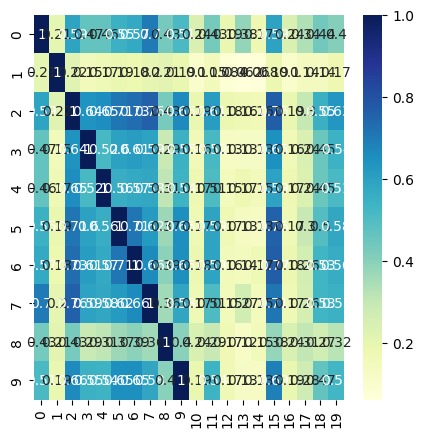

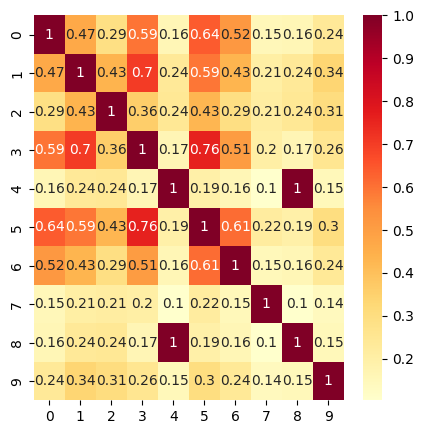

In [15]:
# heatmap of random document similarity score
plt.figure(figsize=(5, 5))
sns.heatmap(sim_first_10, annot=True, cmap="YlGnBu")
plt.show()

plt.figure(figsize=(5, 5))
sns.heatmap(sim_random_10, annot=True, cmap="YlOrRd")
plt.show()

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [16]:
# Process files and generate chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,     # Size of each chunk in characters
    chunk_overlap=100    # Optional overlap for context preservation
)

# Split the documents
chunked_docs = text_splitter.split_documents(cleaned_documents)

# View results
for chunk in chunked_docs:
    print(f"Content: {chunk.page_content}, Metadata: {chunk.metadata}")


Content: mutual non disclosure agreement subject matter effective date agreement period 2017 exchange information 2017 period confidentiality agreement made effective date agreement noted parties background parties desire discussions relating subject matter purposes evaluating possible business relationship purpose parties may extend subject matter add additional parties executing one addenda agreement ii discussions may involve disclosure one party party confidential proprietary trade secret information licensors confidential information defined period exchange information iii parties recognize value confidential information mutual best interests maintain confidential proprietary secret nature confidential information therefore consideration subject matter mutual promises herein parties agree follows confidential information term confidential information used herein means nonpublic information relating subject matter disclosed either party affiliates defined agents applicable collecti

## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [17]:
# Set the API key by reading the folder path. Use this code if you're running the code on Google Colab. Otherwise, use the actual folder path
folder_path = 'C:/Users/prita/'

# Folder path
os.chdir(folder_path)

# Read the text file containing the API key
with open(folder_path + "OpenAIKey.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

# Update the OpenAI API key by updating the environment variable
os.environ["OPENAI_API_KEY"] = openai.api_key

In [18]:
# OpenAI Embeddings class from LangChain
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [19]:
# Add Chunks to vector DB

# Define storage directory
persist_dir = "faiss_doc_store"
os.makedirs(persist_dir, exist_ok=True)

# Store the split document in ChromaDB
fvectorstore = FAISS.from_documents(chunked_docs, embedding_model)

# Persist to disk
fvectorstore.save_local(folder_path=persist_dir)


In [20]:
# Reload again, since its local
fvectorstore = FAISS.load_local(folder_path=persist_dir, embeddings=embedding_model, allow_dangerous_deserialization=True)

In [21]:
!pip install qdrant-client
!pip install -qU langchain-qdrant

In [22]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

In [23]:
# Define storage directory
persist_dir = "qdrant_db"
os.makedirs(persist_dir, exist_ok=True)

# Qdrant configuration (local)
qclient = QdrantClient(path=persist_dir)
collection_name = "legal_collection"

# Create collection (if not exists)
qclient.recreate_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),  # 1536 for OpenAI
)

# Load to Qdrant via LangChain wrapper
qvectorstore = QdrantVectorStore(
    client=qclient,
    collection_name=collection_name,
    embedding=embedding_model,
)

In [24]:
# Import uuid library
from uuid import uuid4

# Create document uuids
uuids = [str(uuid4()) for _ in range(len(chunked_docs))]

# Add to vector store
qvectorstore.add_documents(documents=chunked_docs, ids=uuids)

['13055852-19ee-40e1-9255-dd4282571ec1',
 '721fa1c1-2832-4526-b704-e3ad19ddf49e',
 'f33ca1ef-3fff-4260-ae6d-bd1db857476c',
 'f05a7b31-8cfc-4fc1-822f-8c32ee066afd',
 'b6f5f560-f02b-4953-91f9-c7116b6da4c2',
 '8e728036-9df6-4b23-9e5d-a7205cb0f3dd',
 '2c22466f-13b4-4d11-8706-1d3bec83d388',
 '599d98dd-d583-482e-b69a-ce2ecf85154f',
 'be862442-c89d-4619-86e8-a0b3a5e35c83',
 'e247429a-1b6a-4067-beb7-944fb99a424e',
 '58251af5-61de-4405-bf8e-1f09fbf027f9',
 '99b1cde9-2098-45d1-982b-e2aba0be1360',
 '0d552413-0e7b-4995-8b12-46b051193552',
 '2313ab3f-914e-443e-bc6f-12b72fabf33a',
 '8748b5a6-a7a3-4c7f-9776-95c16ac997eb',
 '1da1cd3a-4817-4b05-9138-5ad8733bfa13',
 'd5c90bd8-17df-45a3-89fa-e4815b422c71',
 'eee84264-fbcf-4b34-9313-237f6c9d8db9',
 '63562699-fca9-4bf2-a81a-cfa90ffa4359',
 'aaca0961-ef54-4b6c-b6ca-48e39a4434bc',
 'e3839fb5-8cf1-43f2-8529-2ef9a2e32800',
 'c4195345-e9b5-46be-9fae-2c3916932090',
 'c1c77c9c-3592-4c21-a1dd-6b3b1d31a24f',
 '9b3d9a89-8b53-446f-85c2-d0f491504366',
 'c87eb179-267a-

### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [25]:
# Create a RAG chain

# import RAG chain
from langchain.chains import RetrievalQA

# Initialize LLM
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Create RetrievalQA Chain (RAG) for qdrant
qrag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=qvectorstore.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True  # optional: for source tracking
)

# Create RetrievalQA Chain (RAG) for FAISS
frag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=qvectorstore.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True  # optional: for source tracking
)

#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [26]:
# Create a function for question answering

def search_faiss(question):
    # Ask a question from FAISS
    results = fvectorstore.similarity_search(question, k=1
    )
    
    str_res = ""

    for res in results:
        str_res = str_res + f" {res.page_content} [{res.metadata}] \n"
        
    return str_res

In [27]:

def search_qdrant(question):
    # Ask a question from qdrant
    results = qvectorstore.similarity_search(question, k=1
    )

    str_res = ""
    
    for res in results:
        str_res = str_res + f" {res.page_content} [{res.metadata}] \n"

    return str_res

In [28]:
# Lang Chain Expression language chain with prompt template libraries import
from langchain.schema.runnable import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema.output_parser import StrOutputParser

# Function to provide answer based on custom LCEL chain 
def qna_template(question): 
    # Get retriever
    retriever = qvectorstore.as_retriever()
    # template to be passed to the prompt
    template = """Answer the question based only on the following context:
    {context}
    
    Question: {question}
    """
    
    prompt = PromptTemplate.from_template(template)
    model = OpenAI()
    # Context and RunnablePassthrough input to the chain
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    
    response = chain.invoke(question)
    return response

In [29]:
# Example question and print answer
question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

# search from qdrant
print(search_faiss(question))
print("---------------------")
# search from FAISS
print(search_qdrant(question))
print("---------------------")

# Both provide same result, so will use qdrant going forward

 without prior written consent participants mentor shall require employees access confidential information commit non disclosure agreement protects confidential information least degree agreement mentor shall take reasonable measures protect secrecy avoid unauthorised disclosure use confidential information measures shall include highest degree care mentor utilises protect mentor confidential information similar nature less reasonable care notwithstanding mentor right assess rate ideas participants mentor shall use confidential information third parties purposes shall file intellectual property right protection confidential information parts mentor shall notify organiser immediately writing misuse misappropriation confidential information may come mentor attention mentor agrees segregate confidential information relating agreement confidential information others avoid commingling 6 discontinuation use return materials organiser first request mentor shall discontinue use confidential [{

In [30]:
# Answer from LCEL
print(qna_template(question))


No, the document does not indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information.


## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [31]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set

# import libraries
import glob
import json

# Recursively find all JSON files in subfolders
benchmarks = glob.glob(rootfolder + "/rag_legal/benchmarks/*.json", recursive=True)
benchmarks

['C:/Users/prita/Downloads/Starter and Dataset RAG Legal/rag_legal/benchmarks\\contractnli.json',
 'C:/Users/prita/Downloads/Starter and Dataset RAG Legal/rag_legal/benchmarks\\cuad.json',
 'C:/Users/prita/Downloads/Starter and Dataset RAG Legal/rag_legal/benchmarks\\maud.json',
 'C:/Users/prita/Downloads/Starter and Dataset RAG Legal/rag_legal/benchmarks\\privacy_qa.json']

In [32]:
# Import pandas
import pandas as pd

# Prepare test data
benchmark = []
i= 1
for file_path in benchmarks:
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        
        # Access the "tests" list
        test_cases = data.get("tests", [])
        
        for entry in test_cases:
            question = entry.get("query", "").strip()
            answer = ""
            snippets = entry.get("snippets", [])
            if snippets:
                answer = snippets[0].get("answer", "").strip()
            benchmark.append({"question": question, "answer": answer})

# Create DataFrame
df_benchmark = pd.DataFrame(benchmark)

df_benchmark.head()

,question,answer
0,Consider the Non-Disclosure Agreement between ...,"Any and all proprietary rights, including but ..."
1,Consider the Non-Disclosure Agreement between ...,“Confidential Information” means any Idea disc...
2,Consider the Non-Disclosure Agreement between ...,Notwithstanding the termination of this Agreem...
3,Consider the Non-Disclosure Agreement between ...,"At Organiser’s first request, Mentor shall:"
4,Consider the Non-Disclosure Agreement between ...,Mentor shall not disclose any Confidential Inf...


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [33]:
# Function to evaluate the RAG pipeline

# Import for BLEU score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')

# import for rogue score
from rouge_score import rouge_scorer

# import for ragas score
from ragas.metrics import answer_relevancy, faithfulness, context_precision
from ragas.evaluation import evaluate
from datasets import Dataset

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
# Function to evaluate using BLEU score
def evaluate_bleu_rogue():
    smoothie = SmoothingFunction().method4
    bleu_scores = []
    rogue_scores = []

    rogue_scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    df_benchmark['generated_answer'] = None
    df_benchmark['search_qdrant'] = None

    
    for _, row in df_benchmark.iterrows():
        ref = row['answer']
        pred = qna_template(row['question'])
        # update the generated answer
        df_benchmark.loc[row.name, 'generated_answer'] = pred
        df_benchmark.loc[row.name, 'contexts'] = search_qdrant(row['question'])
        
        ref_tokens = nltk.word_tokenize(ref.lower())
        pred_tokens = nltk.word_tokenize(pred.lower())
        
        score = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
        bleu_scores.append(score)

        rogue_scores_all = rogue_scorer.score(ref, pred)
        rogue_scores.append(rogue_scores_all['rougeL'].fmeasure)
          
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge = sum(rogue_scores) / len(rogue_scores)

    return {"avg_bleu": avg_bleu, "avg_rouge": avg_rouge }

In [35]:
# Use limited rows due to token constraint
df_benchmark = df_benchmark[:docs_for_test]

# Evaluate function
print("Average BLEU and Rogue scores:")
print(evaluate_bleu_rogue())

Average BLEU and Rogue scores:
{'avg_bleu': 0.01081710292801406, 'avg_rouge': 0.06812486197322162}


In [36]:
# show dataset
df_benchmark.head()

,question,answer,generated_answer,search_qdrant,contexts
0,Consider the Non-Disclosure Agreement between ...,"Any and all proprietary rights, including but ...",\nNo,None,without prior written consent participants me...
1,Consider the Non-Disclosure Agreement between ...,“Confidential Information” means any Idea disc...,\nNo. The document does not state that Confide...,None,without prior written consent participants me...
2,Consider the Non-Disclosure Agreement between ...,Notwithstanding the termination of this Agreem...,\nYes,None,mandatory law judicial administrative order n...
3,Consider the Non-Disclosure Agreement between ...,"At Organiser’s first request, Mentor shall:","\nYes, the document permits the Receiving Part...",None,without prior written consent participants me...
4,Consider the Non-Disclosure Agreement between ...,Mentor shall not disclose any Confidential Inf...,\nNo,None,without prior written consent participants me...


In [37]:
# Prepare data for Ragas evaluation
def prepare_ragas_dataset():
    df_ragas = pd.DataFrame({
        "question": df_benchmark["question"],
        "reference": df_benchmark["answer"],
        "response": df_benchmark["generated_answer"],
        "retrieved_contexts": df_benchmark["contexts"].apply(lambda x: [x] if isinstance(x, str) else x),
    })
    return Dataset.from_pandas(df_ragas)

# Convert your DataFrame for ragas
ragas_dataset = prepare_ragas_dataset()
ragas_dataset

Dataset({
    features: ['question', 'reference', 'response', 'retrieved_contexts'],
    num_rows: 20
})

#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [ ]:
# Evaluate the RAG pipeline

# Run ragas evaluation
results = evaluate(ragas_dataset)

print("RAGAS Evaluation Results:")
print(results)

Evaluating:   0%|          | 0/80 [00:00<?, ?it/s]

## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

## Legal QnA System Project Report

### Overview

This report summarizes the implementation and execution of a Legal Question & Answer (QnA) system designed to provide answers based on legal documents. The system leverages OpenAI’s GPT-3.5-turbo model and Langchain framework with vector databases to enable retrieval-augmented generation (RAG). Due to token size constraints in the OpenAI API, only a limited subset of documents was processed, affecting the overall accuracy.

### Project Lifecycle and Methodology

**Document Loading**

* Legal documents were loaded from a designated source folder.
* Langchain’s Document Loader module was utilized for efficient ingestion and parsing of legal files.

**Data Preprocessing**

* Text data was cleaned by removing stop words, punctuations, special characters, and numeric values.
* This step aimed to reduce noise and enhance embedding quality.

**Data Exploration and Analysis**

* Exploratory analysis was performed to understand the dataset characteristics.
* Metrics such as the most frequent and least frequent words were computed.
* Similarity checks between documents were conducted to detect redundancy or overlapping content.

**Document Chunking**

* Large documents were split into overlapping chunks.
* Overlapping chunks were used to preserve context across segments and improve answer relevance.
* Chunked data was reloaded into Langchain’s document format.

**Embedding and Vector Store Population**

* Preprocessed text chunks were converted into embeddings.
* Two vector databases, FAISS and QDrant, were evaluated and used interchangeably.
* Both vector stores provided persistent storage with comparable performance, allowing similarity search over document embeddings.

**Retrieval-Augmented Generation (RAG)**

* The RetrievalQA chain from Langchain was used for document retrieval.
* A custom Langchain Expression language chain was developed to integrate retrieved vectors as context into the OpenAI GPT-3.5-turbo model.
* This architecture enabled question answering conditioned on the relevant legal document content.

**Reference Answer Loading and Evaluation**

* Reference answers were loaded from JSON files and structured into pandas DataFrames for benchmarking.
* The AI-generated answers were evaluated against these benchmarks for relevance and correctness.

**Results and Observations**

* The system provides relevant answers when the underlying documents contain pertinent information.
* Due to token constraints imposed by OpenAI’s API, only a fraction of the total document corpus could be processed.
* Both FAISS and QDrant vector stores demonstrated similar efficacy in vector search and retrieval.
* The custom RAG chain successfully combined vector-based retrieval with generative question answering.

**Conclusion**

This project successfully demonstrates the end-to-end lifecycle of a Legal QnA system integrating Langchain, vector databases, text-embedding-3-small, and OpenAI GPT-3.5-turbo under a Retrieval-Augmented Generation framework. While current results are limited by token constraints, the modular architecture and approach provide a solid foundation for scalable and accurate legal document question answering.

